In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
from datetime import datetime, timezone, timedelta

In [2]:
#user input, multiple
lakes = ["01004000","01007300","01004600"]

In [3]:
#user input, string
species = "NOP"

In [4]:
#user input, datetime64
start_date = np.datetime64("1900-01-31")

In [5]:
#read .csv files
fish_length_data = pd.read_csv(f"Resources/fish_length_info/fish_lengths.csv",converters={"lake_ID": str})
fish_catch_data = pd.read_csv(f"Resources/fish_catch_info/fish_catch.csv",converters={"lake_ID": str})

In [6]:
#add numeric survey date column as an integer to fish CPUE
fish_catch_df = fish_catch_data
fish_catch_df["survey_date"] = pd.to_datetime(fish_catch_df["survey_date"],format="%Y-%m-%d")
fish_catch_df["numeric_survey_date"] = pd.to_numeric(fish_catch_df["survey_date"])
fish_catch_df = fish_catch_df.sort_values("survey_date")
fish_catch_df = fish_catch_df.reset_index(drop=True)
fish_catch_df.head()

,lake_ID,CPUE,averageWeight,gear,gearCount,quartileCount,quartileWeight,species,survey_ID,survey_date,totalCatch,totalWeight,numeric_survey_date
0,01003100,1.50,0.13,Standard trap nets,4.0,1.8-26.3,0.1-0.4,BLB,113099,1976-07-28,6,0.8,207360000000000000
1,01003100,20.50,0.23,Standard gill nets,2.0,2.5-23.3,0.1-0.2,YEP,113099,1976-07-28,41,9.5,207360000000000000
2,01003100,2.00,0.07,Standard trap nets,4.0,0.3-1.9,0.1-0.1,GOS,113099,1976-07-28,8,0.6,207360000000000000
3,01003100,1.50,0.23,Standard gill nets,2.0,1.5-9.5,0.2-0.7,BRB,113099,1976-07-28,3,0.7,207360000000000000
4,01003100,7.25,0.22,Standard trap nets,4.0,1.9-13.0,0.2-0.4,BLC,113099,1976-07-28,29,6.3,207360000000000000


In [7]:
#add numeric survey date column as an integer to fish length
fish_length_df = fish_length_data
fish_length_df["survey_date"] = pd.to_datetime(fish_length_df["survey_date"],format="%Y-%m-%d")
fish_length_df["numeric_survey_date"] = pd.to_numeric(fish_length_df["survey_date"])
fish_length_df = fish_length_df.sort_values("survey_date")
fish_length_df = fish_length_df.reset_index(drop=True)
fish_length_df.head()

,lake_ID,species,fish_count,maximum_length,minimum_length,survey_ID,survey_date,numeric_survey_date
0,01007300,PMK,"[[4, 4], [5, 2], [6, 4], [7, 1]]",7,4,113360,1993-06-28,741225600000000000
1,01007300,BLG,"[[0, 1], [1, 4], [2, 3], [3, 49], [4, 247], [5...",8,1,113360,1993-06-28,741225600000000000
2,01007300,HSF,"[[6, 1], [7, 1]]",7,6,113360,1993-06-28,741225600000000000
3,01007300,LMB,"[[1, 16], [2, 1], [9, 1]]",9,1,113360,1993-06-28,741225600000000000
4,01007300,BLC,"[[10, 3], [3, 1], [4, 21], [5, 17], [6, 1], [7...",10,3,113360,1993-06-28,741225600000000000


In [8]:
#add methods

#drop strings from cpue data series and convert to int
def cpue_cleaner(dfseries):
    i=0
    for _ in dfseries:
        try:
            np.float64(_)
            i = i + 1
        except ValueError:
            print(i, _,"valueerror")
            dfseries = dfseries.drop([i])
            i = i + 1
    dfseries = pd.to_numeric(dfseries)
    return dfseries

#input fish_catch_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64, gear as str
#returns list of cpue column in dataframe for boxplot
def get_cpue_box(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    cpue_boxplot_list = []
    for lakeid in lakes:
        species_cpue = df.loc[(df["species"] == species) & \
                            (df["gear"] == gear) & \
                            (df["survey_date"] >= start_date) & \
                            (df["lake_ID"] == lakeid), "CPUE"]
        cpue_boxplot_list.append(species_cpue)
    return cpue_boxplot_list

#uses a list format to plot cpue boxplots
def plot_cpue_box(fishlist, lakes):
    plt.boxplot(fishlist)
    labels = lakes
    ticks = range(1, len(lakes)+1)
    plt.xticks(ticks=ticks, labels=labels, rotation=45, ha="right")
    plt.title(species)
    plt.show()

#input string "[[1,2], [2,13], [4,6]]"
#returns fish_count column in dataframe as a list of individual integer measurements e.g. [0,0,1,1,1,2,3,3,4]
def fish_length_cleaner(fishcount):
    fish_lengths = []
    #scrub each row string and convert to list of lengths sampled
    for row in fishcount:
        #clean up string of list syntax
        sample = row.replace("]","").replace("[","").replace(" ","").split(",")
        #breakdown string into list of lengths sampled
        for n in range(len(sample)):
            if n % 2 == 1:
                fishlength = int(sample[n-1])
                fishcount = int(sample[n])
                for c in range(fishcount):
                    fish_lengths.append(fishlength)
    return fish_lengths   

#input length_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#returns dictionary of fish_count column in dataframe for histogram, format {lake ID:[0,0,1,2,2,2,2,3,3]}
def get_length_hist(df, lakes, species, start_date=np.datetime64("1900-01-31")):
    fish_lengths = {}
    for lakeid in lakes:
        #sort by lake and species
        species_length = df.loc[(df["species"] == species) & \
                                    (df["survey_date"] >= start_date) & \
                                    (df["lake_ID"] == lakeid), "fish_count"]
        fish_lengths[lakeid] = fish_length_cleaner(species_length)
    return fish_lengths

#Uses a dictionary format {lake ID:[0,0,1,2,2,2,2,3,3]} to plot fish length histograms
def plot_length_hist(fishdict):
    for lakeid in fishdict.keys():
        if bool(fishdict[lakeid]) == False:
            print(f"{lakeid} did not return results for the timeframe or species specified.")
        else:
            plt.hist(fishdict[lakeid])
            plt.xlabel("Size in Inches")
            plt.ylabel("Number sampled")
            plt.xlim(0,45)
            plt.title(f"{lakeid} {species}")
            plt.show()
            
#input string "[[1,2], [2,13], [4,6]]"
#returns fish_count column in dataframe as a list of float averages e.g. [5.1, 4.6, 8.8]
def fish_length_averager(fishcount):
    fish_length_averages = []
    for row in fishcount:
        sample = row.replace("]","").replace("[","").replace(" ","").split(",")
        #breakdown string into list of lengths found
        mean_numbers = []
        for n in range(len(sample)):
            if n % 2 == 1:
                fishlength = int(sample[n-1])
                fishcount = int(sample[n])
                for c in range(fishcount):
                    mean_numbers.append(fishlength)
        fish_length_averages.append(np.mean(mean_numbers))
    return fish_length_averages

#input cpue_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return cpue data for scatterplot using fish length dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_cpue_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_cpue_list = []
    for lakeid in lakes:
        species_cpue = df.loc[(df["species"] == species) & \
                            (df["survey_date"] >= start_date) & \
                            (df["gear"] == gear) & \
                            (df["lake_ID"] == lakeid), "CPUE"]
        lake_scatter_cpue_list.append(species_cpue)
    return lake_scatter_cpue_list

#input length_df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return avg species length data for scatterplot using fish length dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_avglen_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31")):
    lake_scatter_length_list = []
    for lakeid in lakes:
        species_length = df.loc[(df["species"] == species) & \
                                    (df["survey_date"] >= start_date) & \
                                    (df["lake_ID"] == lakeid), "average_length"]
        lake_scatter_length_list.append(species_length)
    return lake_scatter_length_list

#input df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return survey date data for scatterplot using dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_survey_date_scatter(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_survey_date_list = []
    for lakeid in lakes:
        try:
            species_survey_date = df.loc[(df["species"] == species) & \
                                (df["gear"] == gear) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "survey_date"]
        except KeyError:
            species_survey_date = df.loc[(df["species"] == species) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "survey_date"]            
        lake_scatter_survey_date_list.append(species_survey_date)
    return lake_scatter_survey_date_list

#input df as dataframe, lakes as list of lake id, species as str, start_date as datetime64
#function to return numeric survey date data for regression line using dataframe as df, lakes as a list, species as str, and start date as np.datetime64("1900-01-31") format
def get_numeric_survey_date_regress(df, lakes, species, start_date=np.datetime64("1900-01-31"), gear="Standard gill nets"):
    lake_scatter_numeric_survey_date_list = []
    for lakeid in lakes:
        try:
            lake_scatter_numeric_survey_date = df.loc[(df["species"] == species) & \
                                (df["gear"] == gear) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "numeric_survey_date"]
        except KeyError:
            lake_scatter_numeric_survey_date = df.loc[(df["species"] == species) & \
                                (df["survey_date"] >= start_date) & \
                                (df["lake_ID"] == lakeid), "numeric_survey_date"]            
        lake_scatter_numeric_survey_date_list.append(lake_scatter_numeric_survey_date)
    return lake_scatter_numeric_survey_date_list

#input fish= length or cpue series int, sdate= survey date series datetime64, lakes= [list of lake id], ytext= ylabel value
#scatter plot average lengths per lake
def plot_scatter(fish, sdate, lakes, ytext=""):
    for _ in range(len(lakes)):
        plt.scatter(sdate[_],fish[_], label=lakes[_])
    plt.title(species)
    plt.ylabel(f"{ytext}")
    plt.xlabel("Date")
    plt.xticks(rotation=45, ha="right")
    plt.legend(loc="best")
    plt.show()
    
#plot regression lines with scatter plots for each lake
def plot_regression_scatter(fish, sdate, ndate, lakes, ytext=""):
    print("Notes:")
    for lake in range(len(lakes)):
        if len(ndate[lake]) == 0:
            print(f"Survey Data Empty for {lakes[lake]}")
        elif len(ndate[lake]) == 1:
            print(f"Only 1 data point exists for {lakes[lake]}")
        else:
            regression_values = linregress(ndate[lake],fish[lake])
            fig, ax1 = plt.subplots(1,1)
            fig.suptitle(lakes[lake])
            ax1.scatter(sdate[lake],fish[lake], label=lakes[lake])
            ax1.set_ylabel(f"{species} {ytext}")
            ax1.set_xlabel(f"R value = {regression_values.rvalue}")
            plt.xticks(rotation=45)
            ax2 = ax1.twiny()
            ax2.plot(ndate[lake],(regression_values.slope*ndate[lake] + regression_values.intercept))
    plt.show()

In [9]:
#add average length column to length dataframe
fish_length_averages = fish_length_averager(fish_length_df["fish_count"])
fish_length_df["average_length"] = pd.Series(fish_length_averages)

In [10]:
#clean the CPUE series
fish_catch_df["CPUE"] = cpue_cleaner(fish_catch_df["CPUE"])

In [11]:
#create date series for length scatter plots and regression lines
length_sdate = get_survey_date_scatter(fish_length_df, lakes, species, start_date)
length_ndate = get_numeric_survey_date_regress(fish_length_df, lakes, species, start_date)

In [12]:
#create date series for cpue scatter plots and regression lines
cpue_sdate = get_survey_date_scatter(fish_catch_df, lakes, species, start_date)
cpue_ndate = get_numeric_survey_date_regress(fish_catch_df, lakes, species, start_date)

In [13]:
#filter and prepare a CPUE list for box plots
cpuelist = get_cpue_box(fish_catch_df, lakes, species, start_date)

In [14]:
#filter and prepare a list of lengths for histogram plots
lengthdict = get_length_hist(fish_length_df, lakes, species, start_date)

In [15]:
#create fish CPUE data series for scatter plot and regression line
fish_cpue = get_cpue_scatter(fish_catch_df, lakes, species, start_date)

In [16]:
#create fish length data series for scatter plot and regression line
fishavglength = get_avglen_scatter(fish_length_df, lakes, species, start_date)

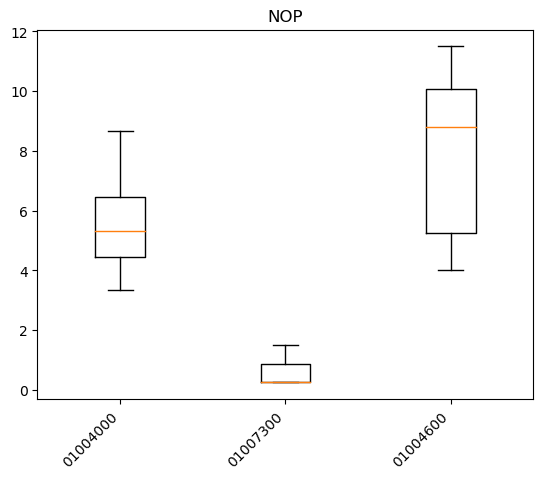

In [17]:
#plot boxplot of CPUE per lake
plot_cpue_box(cpuelist, lakes)

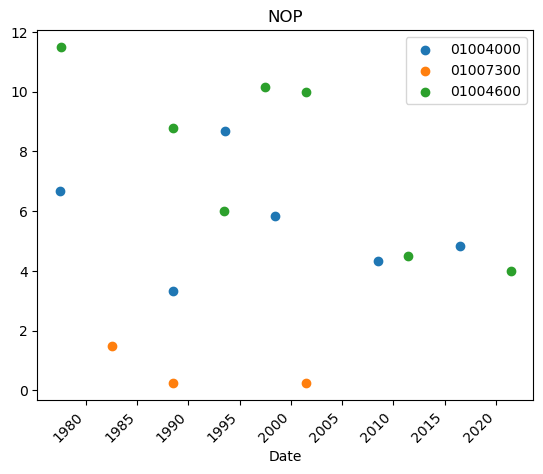

In [18]:
#plot scatter of CPUE per lake
plot_scatter(fish_cpue, cpue_sdate, lakes)

Notes:


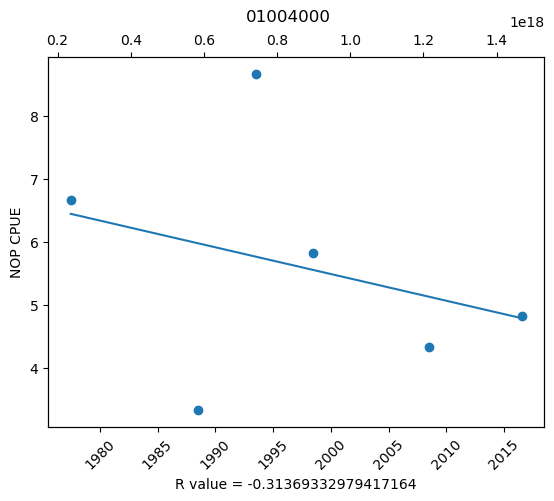

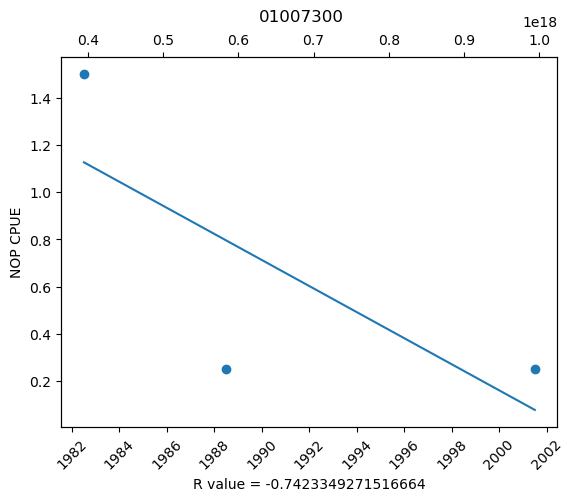

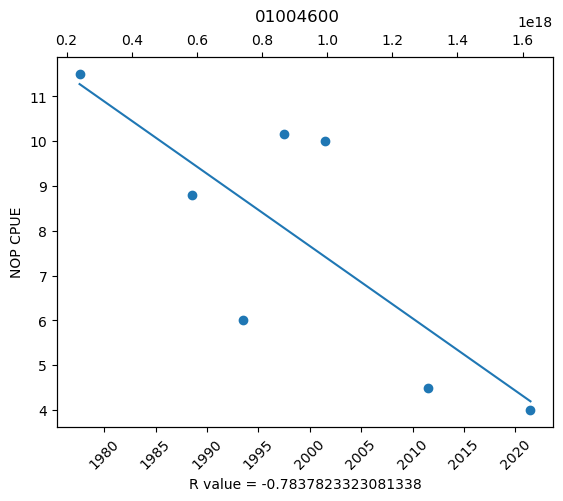

In [19]:
#plot regression lines for each lake CPUE over time
plot_regression_scatter(fish_cpue, cpue_sdate, cpue_ndate, lakes, "CPUE")

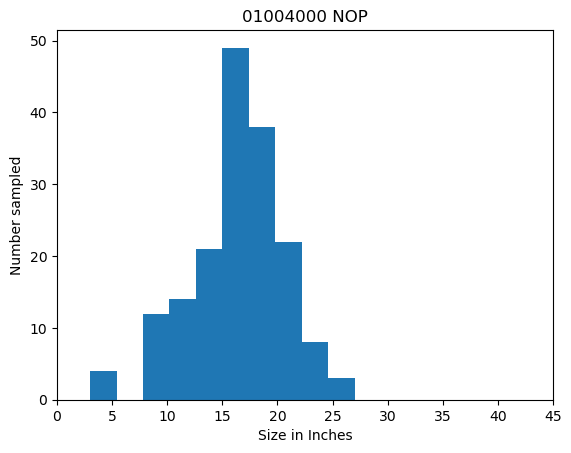

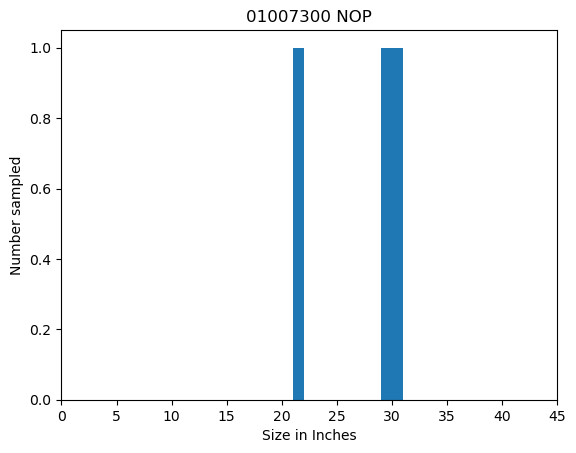

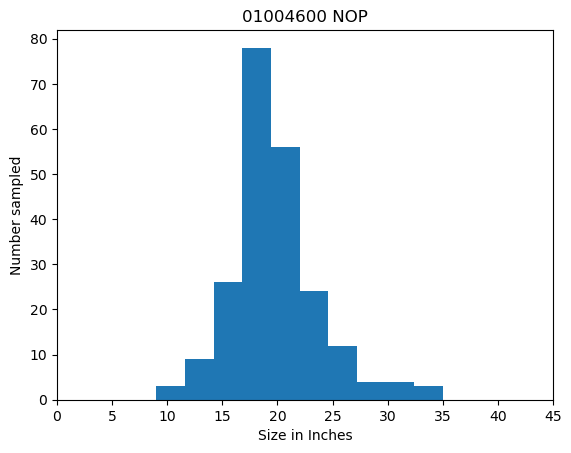

In [20]:
#plot histograms of lengths per lake
plot_length_hist(lengthdict)

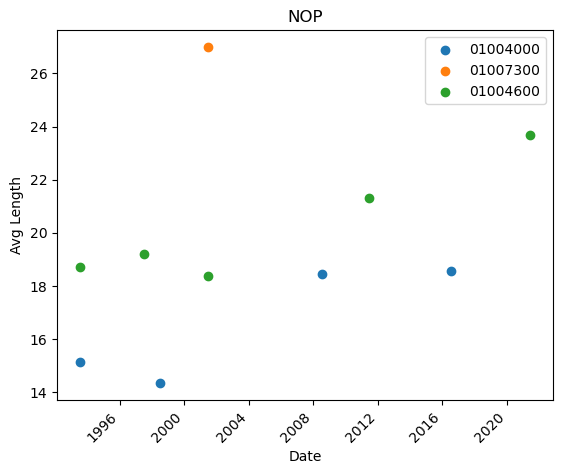

In [21]:
#plot scatter of average fish lengths per lake
plot_scatter(fishavglength, length_sdate, lakes, "Avg Length")

Notes:
Only 1 data point exists for 01007300


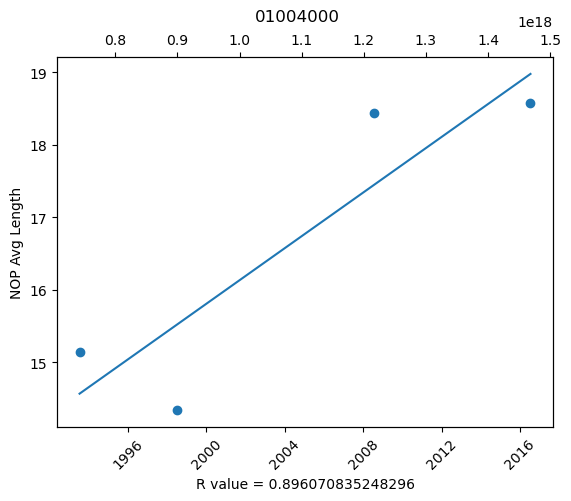

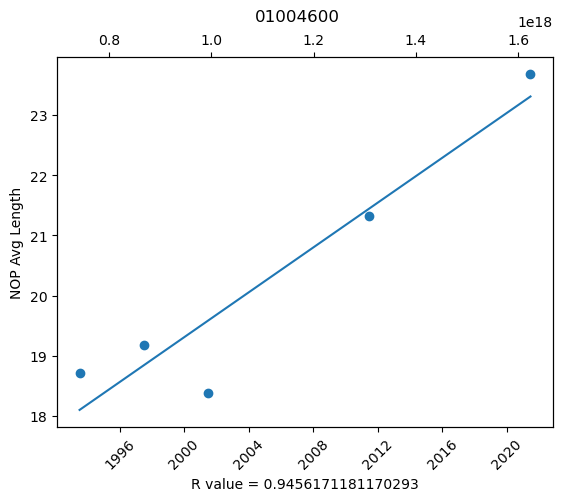

In [22]:
#plot regression lines for each lake average fish length over time
plot_regression_scatter(fishavglength, length_sdate, length_ndate, lakes, "Avg Length")